<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/DNN_photoz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Supervised Regression problem

In this notebook we will use neural network algorihtms to learn a mapping between galaxy magnitudes and colors and the spectroscopic redshift.



# Load some libraries

In [1]:
pip install astroquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 47.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 7.3 MB/s eta 0:00:00


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from sklearn.model_selection import train_test_split

# Doanload the dataset

In [3]:
from astroquery.sdss import SDSS

# look for availabe tables and columns in
# http://skyserver.sdss.org/dr12/en/help/browser/browser.aspx

query = " SELECT TOP 200000 objID, ra ,dec, z, zerr, class, \
        cModelMag_r as mag_r, cModelMag_g as mag_g, cModelMag_i as mag_i, \
        cModelMag_u as mag_u, cModelMag_z as mag_z \
        FROM  SpecPhotoAll  WHERE (class = 'GALAXY') \
        AND z>0.1 AND z<1. AND ra>200 AND ra<230 AND dec>10 AND dec<40"


d = SDSS.query_sql(query)

/usr/local/lib/python3.10/dist-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),


# Clean the data

In [4]:
#you can look at the all the features available to you
# http://skyserver.sdss.org/dr14/en/help/browser/browser.aspx#&&history=description+PhotoObj+V
print (d.keys())

['objID', 'ra', 'dec', 'z', 'zerr', 'class', 'mag_r', 'mag_g', 'mag_i', 'mag_u', 'mag_z']


# for photo-z work
# The target/label values are spectroscopic redshifts

In [59]:
# we will use just dereddend magnitudes
mags = ['mag_g', 'mag_r', 'mag_i','mag_z','mag_u']
d=d[d[mags[0]]==d[mags[0]]]
d=d[d[mags[1]]==d[mags[1]]]
d=d[d[mags[2]]==d[mags[2]]]
d=d[d[mags[3]]==d[mags[3]]]
d=d[d[mags[4]]==d[mags[4]]]

def f(x):
    return float(x)
f2 = np.vectorize(f)

#and color combinations created from them.
cols= []
for i in range(len(mags)-1):
    for j in range(i, len(mags)):
        cols.append(mags[i]+'-' + mags[j])

# let's load these into an input array
inputs = np.zeros((len(d), len(mags+cols)), dtype=float)
inputs = np.zeros((len(d), len(mags)), dtype=float)
for i, key in enumerate(mags):
    inputs[:, i] = np.array(d[key])

#cnt = len(mags)
#for i in range(len(mags)-1):
#    for j in range(i, len(mags)):
#        inputs[:, cnt] = np.array(f2(d[mags[i]])) - np.array(f2(d[mags[j]]))
#        cnt += 1


In [60]:
targets = np.array(f2(d['z']))

# we will split the data into a trainind and testing sample.


In [61]:
x_train, x_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=42)

print("Training inputs: ",x_train.shape)
print("Training outputs: ",y_train.shape)
print("Testing inputs: ",x_test.shape)
print("Testing outputs: ",y_test.shape)

Training inputs:  (121325, 5)
Training outputs:  (121325,)
Testing inputs:  (30332, 5)
Testing outputs:  (30332,)


In [ ]:
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

#see https://scikit-learn.org/stable/modules/tree.html

#help(DT)

#let's train [.fit()]  a tree on the training sample, and then make predictions on the test sample

0.006038031284484726 0.00606425879803211


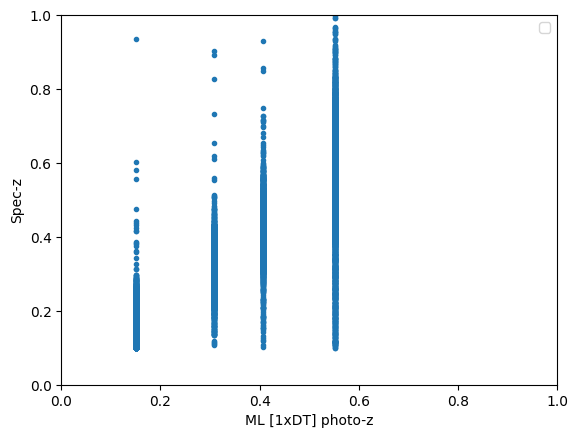

In [ ]:
clf = DT(random_state=0, max_depth=2)
clf = clf.fit(x_train, y_train)

pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, '.')#, label='test MSE={:0.2f}'.format(mse_test))
plt.legend()
plt.xlabel('ML [1xDT] photo-z')
plt.ylabel('Spec-z')
plt.xlim([0,1])
plt.ylim([0,1])

print(mse_test, mse_train)


# Show graph

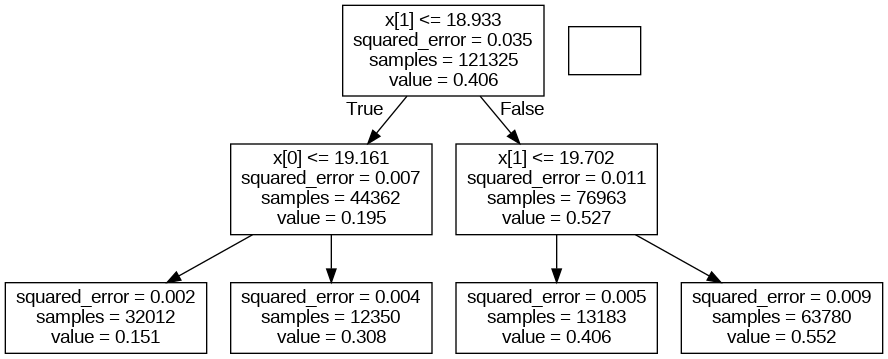

In [ ]:
#from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus

dot_data=export_graphviz(clf)

graph = pydotplus.graph_from_dot_data(dot_data)

Image(graph.create_png())

# Lets increase the number of trees -> forest

In [ ]:
#for regression [photo-z]
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor

clf = RandomForestRegressor(max_depth=6,n_estimators=10)

0.004222096511832545 0.004211296354918545


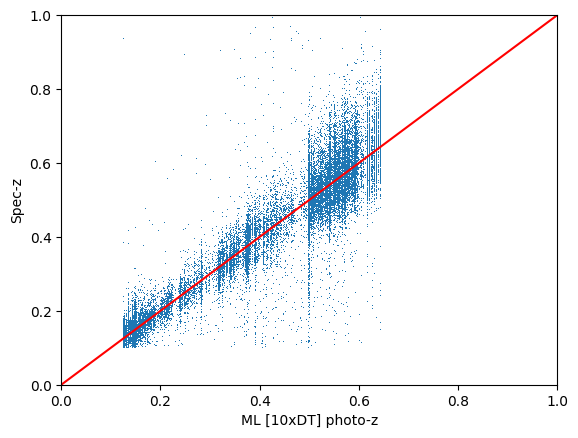

In [ ]:
clf = clf.fit(x_train, y_train)

#replace None
pred_train  = clf.predict(x_train)
pred_test = clf.predict(x_test)

mse_test = mean_squared_error(y_test, pred_test)
mse_train = mean_squared_error(y_train, pred_train)
plt.plot(pred_test,y_test, ',')#, label='test MSE={:0.2f}'.format(mse_test))
plt.xlabel('ML [10xDT] photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1],[0,1],'r-')
plt.xlim([0,1])
plt.ylim([0,1])

print(mse_test, mse_train)

(0.0, 1.0)

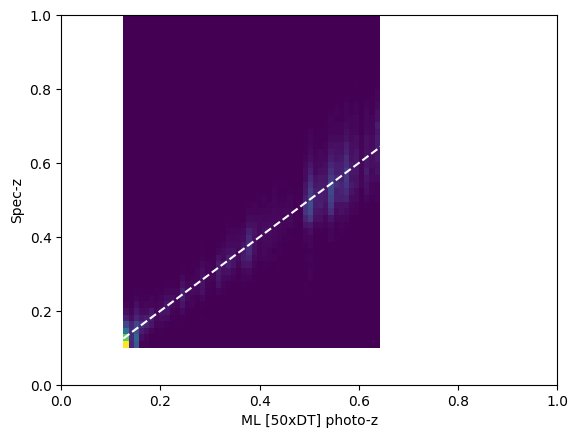

In [ ]:
plt.hist2d(pred_test,y_test, bins=50)
plt.xlabel('ML [50xDT] photo-z')
plt.ylabel('Spec-z')
plt.plot([0,1],[0,1],'w--')
plt.xlim([0,1])
plt.ylim([0,1])

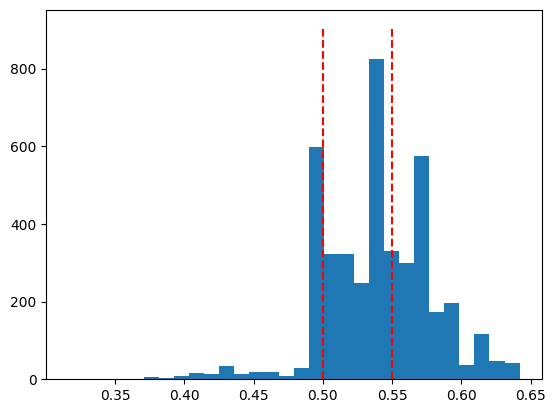

In [ ]:
specz=[0.5,0.55]
a=plt.hist(pred_test[(y_test>specz[0]) & (y_test<specz[1])],30)
plt.plot([specz[0],specz[0]],[0,1.1*np.max(a[0])],'r--')
plt.plot([specz[1],specz[1]],[0,1.1*np.max(a[0])],'r--')

In [9]:
import tensorflow as tf

In [87]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(5,)),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Dense(64, activation=tf.keras.layers.LeakyReLU()),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.AdamW(0.0005))

In [88]:
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_68 (Dense)            (None, 64)                384       
                                                                 
 dense_69 (Dense)            (None, 64)                4160      
                                                                 
 dense_70 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
1517/1517 [==============================] - 8s 4ms/step - loss: 0.0950 - val_loss: 0.0654
Epoch 2/10
1517/1517 [==============================] - 5s 4ms/step - loss: 0.0695 - val_loss: 0.0566
Epoch 3/10
1517/1517 [==============================] - 7s 4ms/step - loss: 0.0635 - val_loss: 0.0754
Epoch 4/10
1517/1517 [==============================] - 5s 4ms/step - loss: 0.0603 - val_loss: 0.0630
Epoch 5/10
 593/1517 [==========>...................] - ETA: 2s - loss: 0.0583

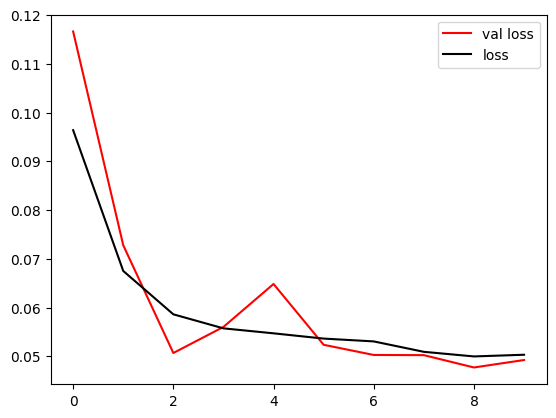

In [68]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.legend()

948/948 [==============================] - 1s 2ms/step


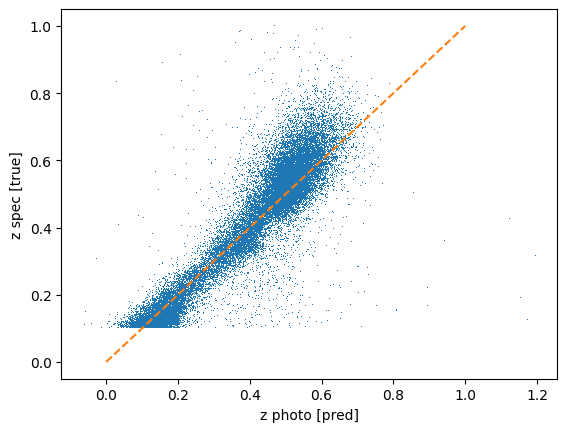

In [69]:
pred=model.predict(x_test).squeeze()
pred
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()

In [71]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(5,)),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
model.build()

In [72]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=10,batch_size=64,shuffle=True)

Epoch 1/10
1517/1517 [==============================] - 9s 5ms/step - loss: 0.0935 - val_loss: 0.0554
Epoch 2/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0570 - val_loss: 0.0693
Epoch 3/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0538 - val_loss: 0.0577
Epoch 4/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0537 - val_loss: 0.0487
Epoch 5/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0518 - val_loss: 0.0492
Epoch 6/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0508 - val_loss: 0.0462
Epoch 7/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0498 - val_loss: 0.0608
Epoch 8/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0489 - val_loss: 0.0504
Epoch 9/10
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0473 - val_loss: 0.0527
Epoch 10/10
1517/1517 [==============================] - 6s 4ms/step - loss: 0.047

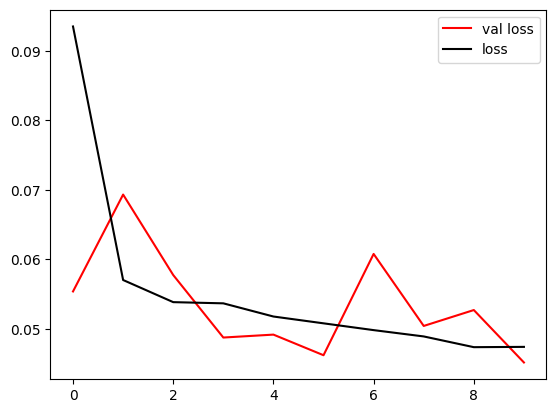

In [74]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.legend()

948/948 [==============================] - 2s 2ms/step


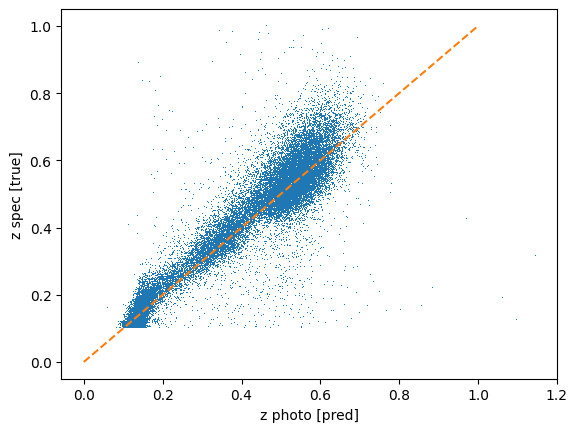

In [75]:
pred=model.predict(x_test).squeeze()
plt.plot(pred,y_test,',')
plt.plot([0, 1],[0, 1],'--')
plt.ylabel('z spec [true]')
plt.xlabel('z photo [pred]')
plt.show()


In [56]:
model = tf.keras.Sequential([
      tf.keras.layers.Input(shape=(19,)),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(16, activation='relu'),
      tf.keras.layers.Dense(1)
  ])
model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.0005))

In [57]:
hist=model.fit(x_train,y_train,validation_split=0.2,epochs=15,batch_size=64,shuffle=True)

Epoch 1/15
1517/1517 [==============================] - 7s 4ms/step - loss: 0.6538 - val_loss: 0.0630
Epoch 2/15
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0619 - val_loss: 0.0543
Epoch 3/15
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0567 - val_loss: 0.0532
Epoch 4/15
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0546 - val_loss: 0.0615
Epoch 5/15
1517/1517 [==============================] - 11s 7ms/step - loss: 0.0525 - val_loss: 0.0499
Epoch 6/15
1517/1517 [==============================] - 7s 5ms/step - loss: 0.0520 - val_loss: 0.0604
Epoch 7/15
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0515 - val_loss: 0.0483
Epoch 8/15
1517/1517 [==============================] - 5s 3ms/step - loss: 0.0518 - val_loss: 0.0554
Epoch 9/15
1517/1517 [==============================] - 6s 4ms/step - loss: 0.0510 - val_loss: 0.0742
Epoch 10/15
1517/1517 [==============================] - 5s 3ms/step - loss: 0.05

KeyboardInterrupt: ignored

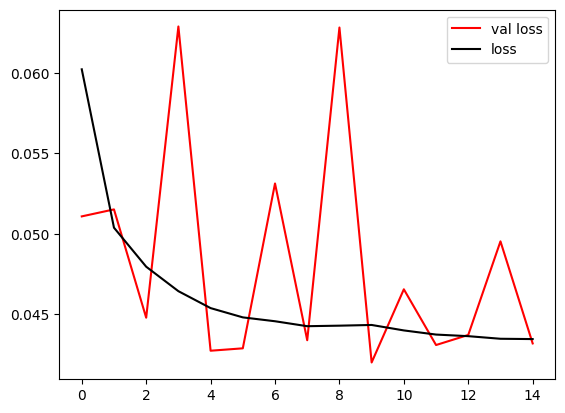

In [58]:
plt.plot(hist.history['val_loss'],'r-',label='val loss')
plt.plot(hist.history['loss'],'k-',label='loss')
plt.legend()